## Analyze Dermatology Data using PCA and K-Means Clustering 
- Problem: Hard to diagnose different dermatology diseases because they have similar clinical and histopathological features
- Goals: 
    1. Use K-Means clustering to find six groupings of dermatology disease
    2. Use PCA to reduce feature space dimensionality in order to visualize the clustering
    3. Use PC loading scores to undertand how the diseases are different in terms of features
    4. Explore other clustering methods and see how well they map to the true disease classes
    
- Data source: https://archive.ics.uci.edu/ml/datasets/Dermatology        

In [831]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.getcwd()

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

'C:\\Users\\tuttoaposto\\Desktop\\My_Py_Projects\\OpenSource'

### Import Data

In [33]:
col_name = ['erythema', 
            'scaling', 
            'definite borders', 
            'itching', 
            'koebner phenomenon', 
            'polygonal papules', 
            'follicular papules', 
            'oral mucosal involvement', 
            'knee and elbow involvement', 
            'scalp involvement', 
            'family history, (0 or 1)', 
            'melanin incontinence', 
            'eosinophils in the infiltrate', 
            'PNL infiltrate', 
            'fibrosis of the papillary dermis', 
            'exocytosis', 
            'acanthosis', 
            'hyperkeratosis', 
            'parakeratosis', 
            'clubbing of the rete ridges', 
            'elongation of the rete ridges', 
            'thinning of the suprapapillary epidermis', 
            'spongiform pustule', 
            'munro microabcess', 
            'focal hypergranulosis', 
            'disappearance of the granular layer', 
            'vacuolisation and damage of basal layer', 
            'spongiosis', 
            'saw-tooth appearance of retes', 
            'follicular horn plug', 
            'perifollicular parakeratosis', 
            'inflammatory monoluclear inflitrate', 
            'band-like infiltrate', 
            'Age (linear)', 
            'Class_Code']

df = pd.read_csv('derm.txt', sep=",", names=col_name, na_values='?')
df['Class'] = df['Class_Code'].map({1: 'psoriasis',
                                    2: 'seboreic dermatitis',
                                    3: 'lichen planus',
                                    4: 'pityriasis rosea',
                                    5: 'cronic dermatitis',
                                    6: 'pityriasis rubra pilaris'})
df.head()

erythema  scaling  definite borders  itching  koebner phenomenon  \
0         2        2                 0        3                   0   
1         3        3                 3        2                   1   
2         2        1                 2        3                   1   
3         2        2                 2        0                   0   
4         2        3                 2        2                   2   

   polygonal papules  follicular papules  oral mucosal involvement  \
0                  0                   0                         0   
1                  0                   0                         0   
2                  3                   0                         3   
3                  0                   0                         0   
4                  2                   0                         2   

   knee and elbow involvement  scalp involvement  ...  \
0                           1                  0  ...   
1                           1                  1  ...   
2                           0                  0  ...   
3                           3                  2  ...   
4                           0                  0  ...   

   vacuolisation and damage of basal layer  spongiosis  \
0                                        0           3   
1                                        0           0   
2                                        2           3   
3                                        0           0   
4                                        3           2   

   saw-tooth appearance of retes  follicular horn plug  \
0                              0                     0   
1                              0                     0   
2                              2                     0   
3                              0                     0   
4                              3                     0   

   perifollicular parakeratosis  inflammatory monoluclear inflitrate  \
0                             0                                    1   
1                             0                                    1   
2                             0                                    2   
3                             0                                    3   
4                             0                                    2   

   band-like infiltrate  Age (linear)  Class_Code                Class  
0                     0          55.0           2  seboreic dermatitis  
1                     0           8.0           1            psoriasis  
2                     3          26.0           3        lichen planus  
3                     0          40.0           1            psoriasis  
4                     3          45.0           3        lichen planus  

[5 rows x 36 columns]

In [20]:
df.groupby(['Class_Code', 'Class']).size()

Class_Code  Class                   
1           psoriasis                   112
2           seboreic dermatitis          61
3           lichen planus                72
4           pityriasis rosea             49
5           cronic dermatitis            52
6           pityriasis rubra pilaris     20
dtype: int64

### Check Distribution

In [50]:
# df.dtypes
sum(df['Age (linear)'].isna())
df.iloc[:, 0:10].describe()
df.iloc[:, 10:20].describe()
df.iloc[:, 20:30].describe()
df.iloc[:, 30:].describe()

8

erythema     scaling  definite borders     itching  \
count  366.000000  366.000000        366.000000  366.000000   
mean     2.068306    1.795082          1.549180    1.366120   
std      0.664753    0.701527          0.907525    1.138299   
min      0.000000    0.000000          0.000000    0.000000   
25%      2.000000    1.000000          1.000000    0.000000   
50%      2.000000    2.000000          2.000000    1.000000   
75%      2.000000    2.000000          2.000000    2.000000   
max      3.000000    3.000000          3.000000    3.000000   

       koebner phenomenon  polygonal papules  follicular papules  \
count          366.000000         366.000000          366.000000   
mean             0.633880           0.448087            0.166667   
std              0.908016           0.957327            0.570588   
min              0.000000           0.000000            0.000000   
25%              0.000000           0.000000            0.000000   
50%              0.000000           0.000000            0.000000   
75%              1.000000           0.000000            0.000000   
max              3.000000           3.000000            3.000000   

       oral mucosal involvement  knee and elbow involvement  scalp involvement  
count                366.000000                  366.000000         366.000000  
mean                   0.377049                    0.614754           0.519126  
std                    0.834147                    0.982979           0.905639  
min                    0.000000                    0.000000           0.000000  
25%                    0.000000                    0.000000           0.000000  
50%                    0.000000                    0.000000           0.000000  
75%                    0.000000                    1.000000           1.000000  
max                    3.000000                    3.000000           3.000000

family history, (0 or 1)  melanin incontinence  \
count                366.000000            366.000000   
mean                   0.125683              0.404372   
std                    0.331946              0.869818   
min                    0.000000              0.000000   
25%                    0.000000              0.000000   
50%                    0.000000              0.000000   
75%                    0.000000              0.000000   
max                    1.000000              3.000000   

       eosinophils in the infiltrate  PNL infiltrate  \
count                     366.000000      366.000000   
mean                        0.139344        0.546448   
std                         0.411790        0.815451   
min                         0.000000        0.000000   
25%                         0.000000        0.000000   
50%                         0.000000        0.000000   
75%                         0.000000        1.000000   
max                         2.000000        3.000000   

       fibrosis of the papillary dermis  exocytosis  acanthosis  \
count                        366.000000  366.000000  366.000000   
mean                           0.336066    1.368852    1.956284   
std                            0.853139    1.104418    0.712512   
min                            0.000000    0.000000    0.000000   
25%                            0.000000    0.000000    2.000000   
50%                            0.000000    2.000000    2.000000   
75%                            0.000000    2.000000    2.000000   
max                            3.000000    3.000000    3.000000   

       hyperkeratosis  parakeratosis  clubbing of the rete ridges  
count      366.000000     366.000000                   366.000000  
mean         0.527322       1.289617                     0.663934  
std          0.757116       0.917562                     1.056829  
min          0.000000       0.000000                     0.000000  
25%          0.000000       1.000000                     0.000000  
50%          0.000000       1.000000                     0.000000  
75%          1.000000       2.000000                     2.000000  
max          3.000000       3.000000                     3.000000

elongation of the rete ridges  \
count                     366.000000   
mean                        0.991803   
std                         1.162161   
min                         0.000000   
25%                         0.000000   
50%                         0.000000   
75%                         2.000000   
max                         3.000000   

       thinning of the suprapapillary epidermis  spongiform pustule  \
count                                366.000000          366.000000   
mean                                   0.633880            0.295082   
std                                    1.034924            0.670578   
min                                    0.000000            0.000000   
25%                                    0.000000            0.000000   
50%                                    0.000000            0.000000   
75%                                    1.000000            0.000000   
max                                    3.000000            3.000000   

       munro microabcess  focal hypergranulosis  \
count         366.000000             366.000000   
mean            0.363388               0.393443   
std             0.759721               0.849406   
min             0.000000               0.000000   
25%             0.000000               0.000000   
50%             0.000000               0.000000   
75%             0.000000               0.000000   
max             3.000000               3.000000   

       disappearance of the granular layer  \
count                           366.000000   
mean                              0.464481   
std                               0.864899   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               1.000000   
max                               3.000000   

       vacuolisation and damage of basal layer  spongiosis  \
count                               366.000000  366.000000   
mean                                  0.456284    0.953552   
std                                   0.954873    1.130172   
min                                   0.000000    0.000000   
25%                                   0.000000    0.000000   
50%                                   0.000000    0.000000   
75%                                   0.000000    2.000000   
max                                   3.000000    3.000000   

       saw-tooth appearance of retes  follicular horn plug  
count                     366.000000            366.000000  
mean                        0.453552              0.103825  
std                         0.954744              0.450433  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         0.000000              0.000000  
75%                         0.000000              0.000000  
max                         3.000000              3.000000

perifollicular parakeratosis  inflammatory monoluclear inflitrate  \
count                    366.000000                           366.000000   
mean                       0.114754                             1.866120   
std                        0.488723                             0.726108   
min                        0.000000                             0.000000   
25%                        0.000000                             1.000000   
50%                        0.000000                             2.000000   
75%                        0.000000                             2.000000   
max                        3.000000                             3.000000   

       band-like infiltrate  Age (linear)  Class_Code  
count            366.000000    358.000000  366.000000  
mean               0.554645     36.296089    2.803279  
std                1.105908     15.324557    1.597803  
min                0.000000      0.000000    1.000000  
25%                0.000000     25.000000    1.000000  
50%                0.000000     35.000000    3.000000  
75%                0.000000     49.750000    4.000000  
max                3.000000     75.000000    6.000000

<IPython.core.display.Javascript object>


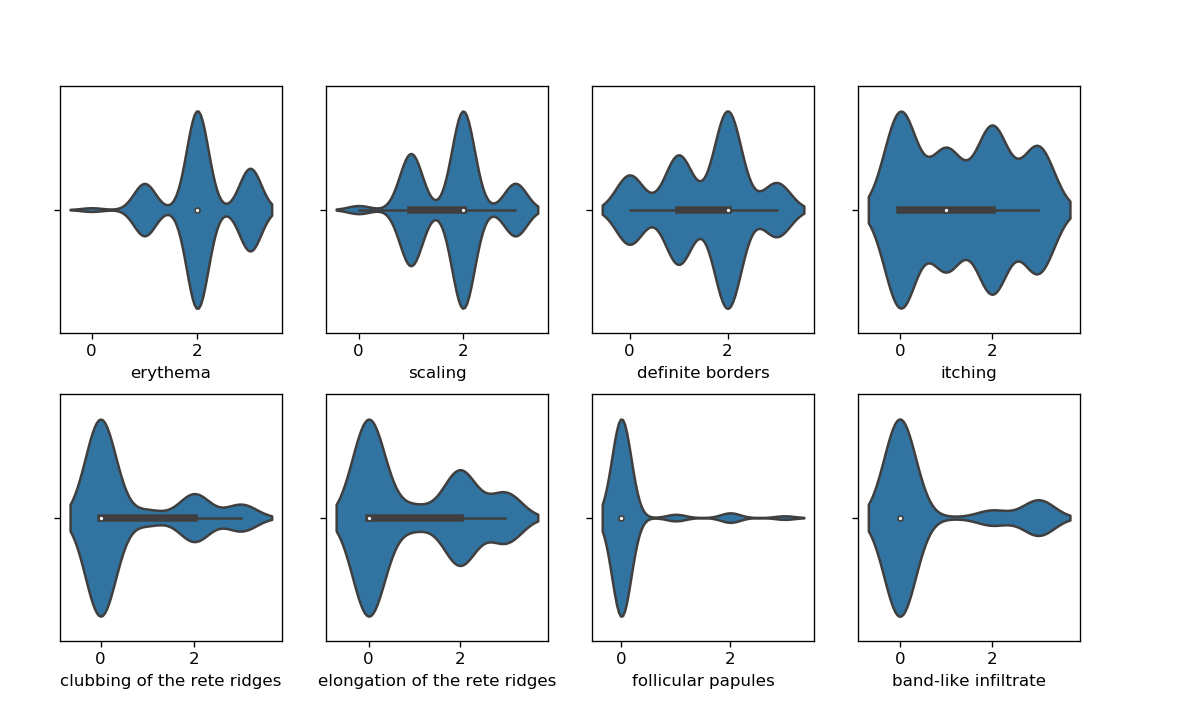

In [1082]:
%matplotlib notebook
fig, [ax1, ax2] = plt.subplots(figsize=(10,6), nrows=2, ncols=4)
    
for k, ax in enumerate([ax1, ax2]):
    if k==0:
        cols = ['erythema', 
                'scaling', 
                'definite borders', 
                'itching']
    if k==1:
        cols = ['clubbing of the rete ridges',
                'elongation of the rete ridges',
                'follicular papules',
                'band-like infiltrate']
    for i, col in enumerate(cols):
        sns.violinplot(x = col, data=df, ax=ax[i])
       

fig.subplots_adjust(left=0.05, hspace = 0.25)
pass;

<IPython.core.display.Javascript object>


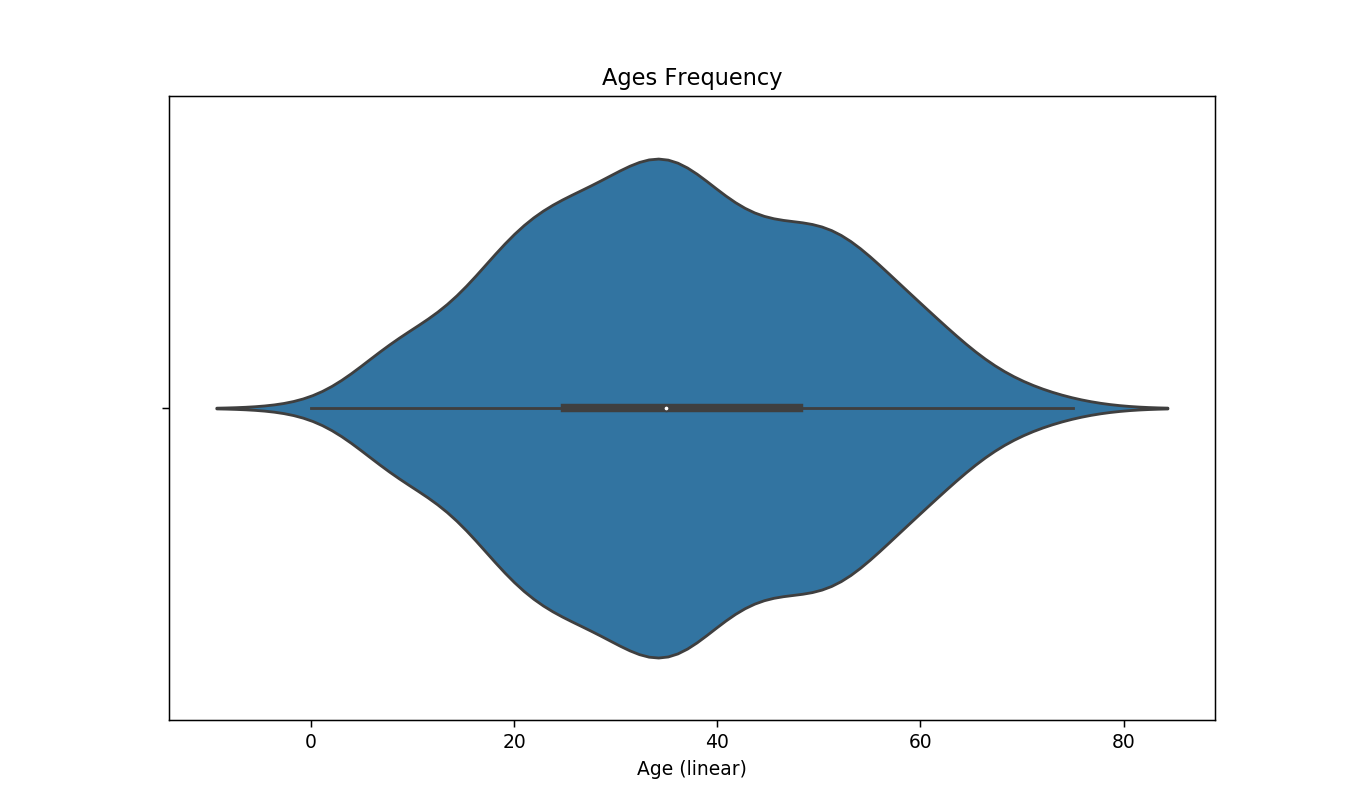

<IPython.core.display.Javascript object>


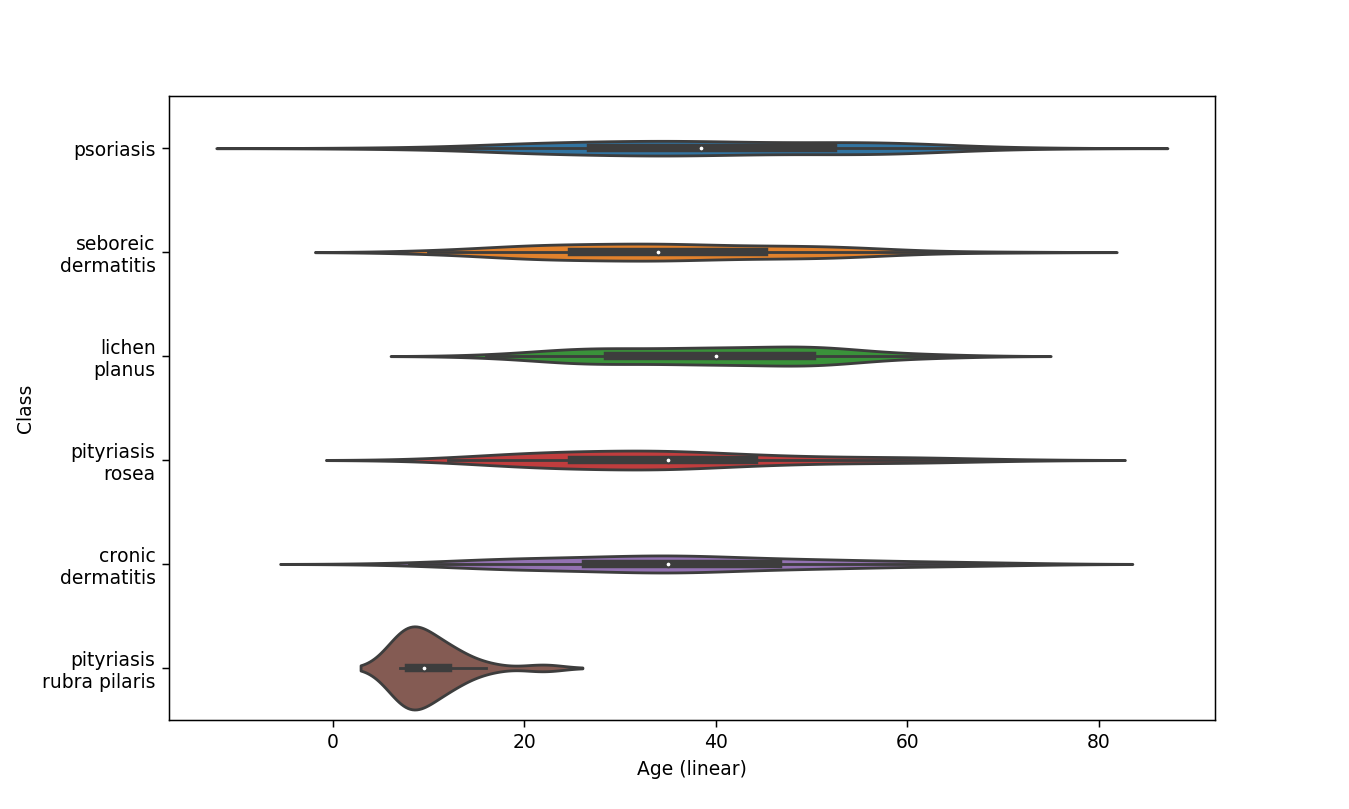

In [208]:
%matplotlib notebook
plt.figure(figsize=(10,6))
plt.title("Ages Frequency")
sns.axes_style("dark")
sns.violinplot(x = 'Age (linear)', data=df)

plt.figure(figsize=(10,6))
ax=sns.violinplot(x = 'Age (linear)', y = 'Class', data=df.sort_values(by='Class_Code'))
ax.set_yticklabels(labels=['psoriasis',
                          'seboreic\ndermatitis',
                          'lichen\nplanus',
                          'pityriasis\nrosea',
                          'cronic\ndermatitis',
                          'pityriasis\nrubra pilaris']);

- Majority of the patients were aged 30 - 50 years
- Patients with pitriasis rubra pilaris were under age 30 years

### Correlation between Features

<IPython.core.display.Javascript object>


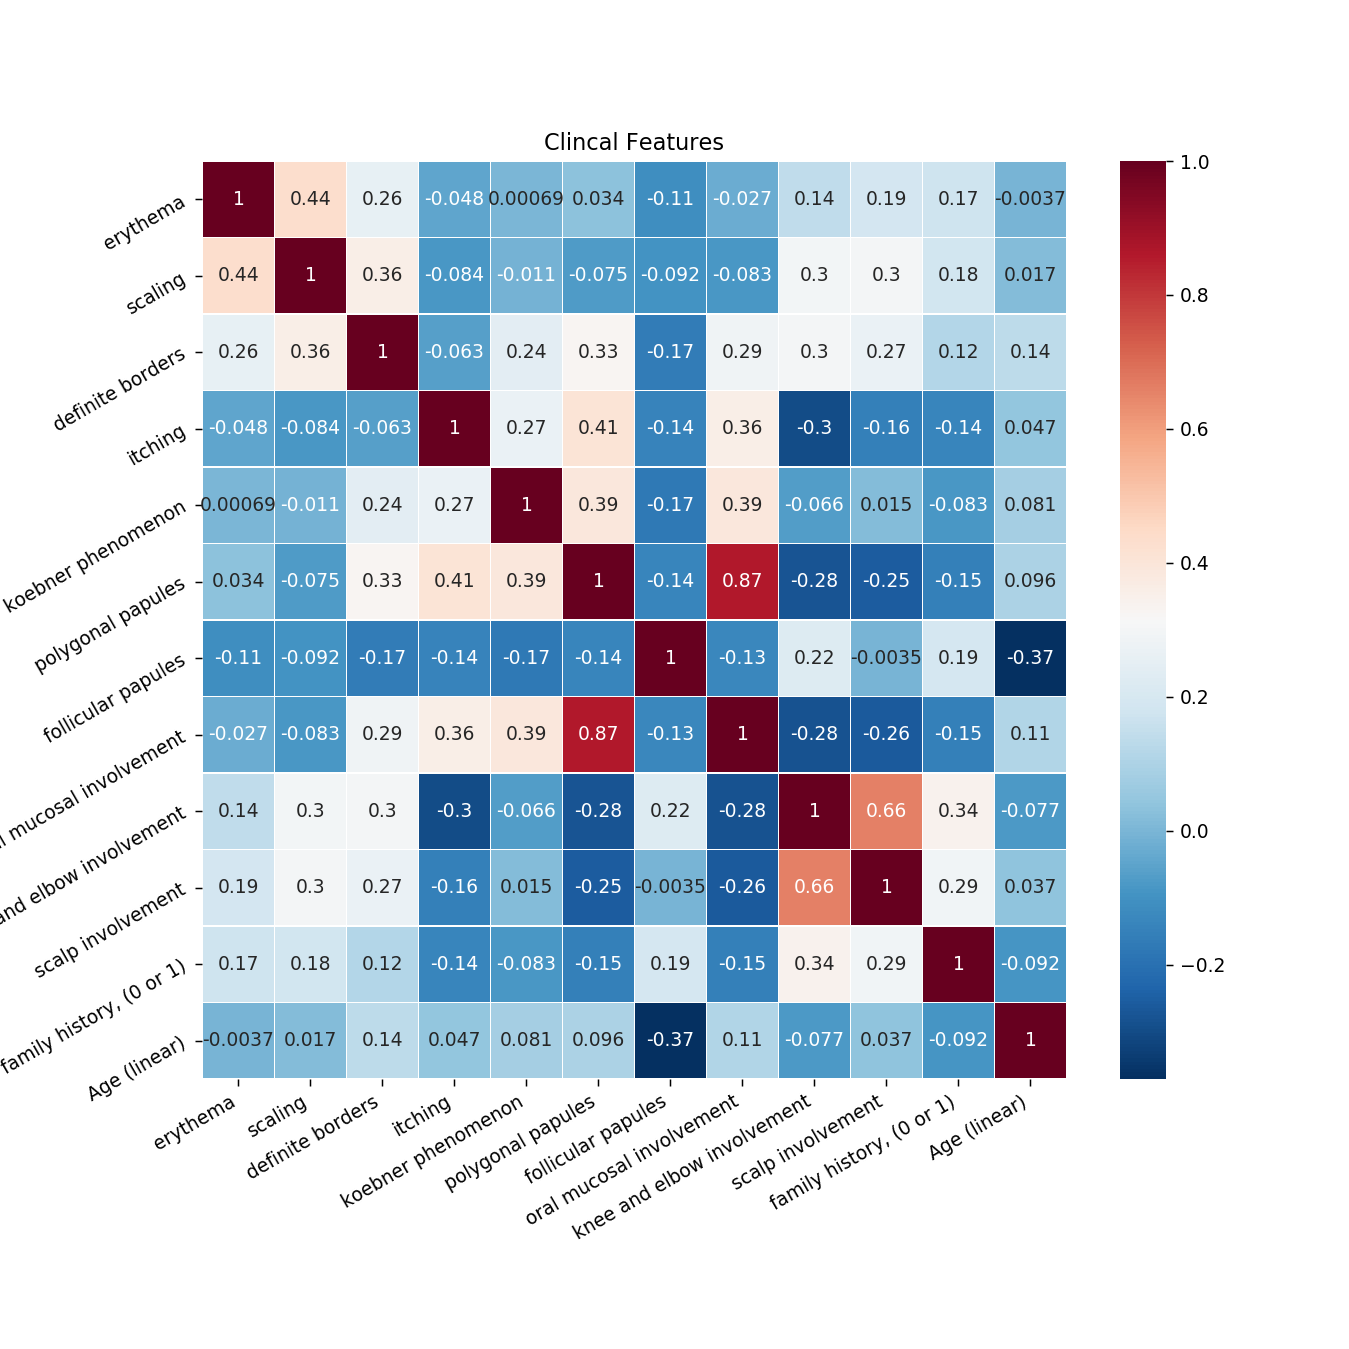

<IPython.core.display.Javascript object>


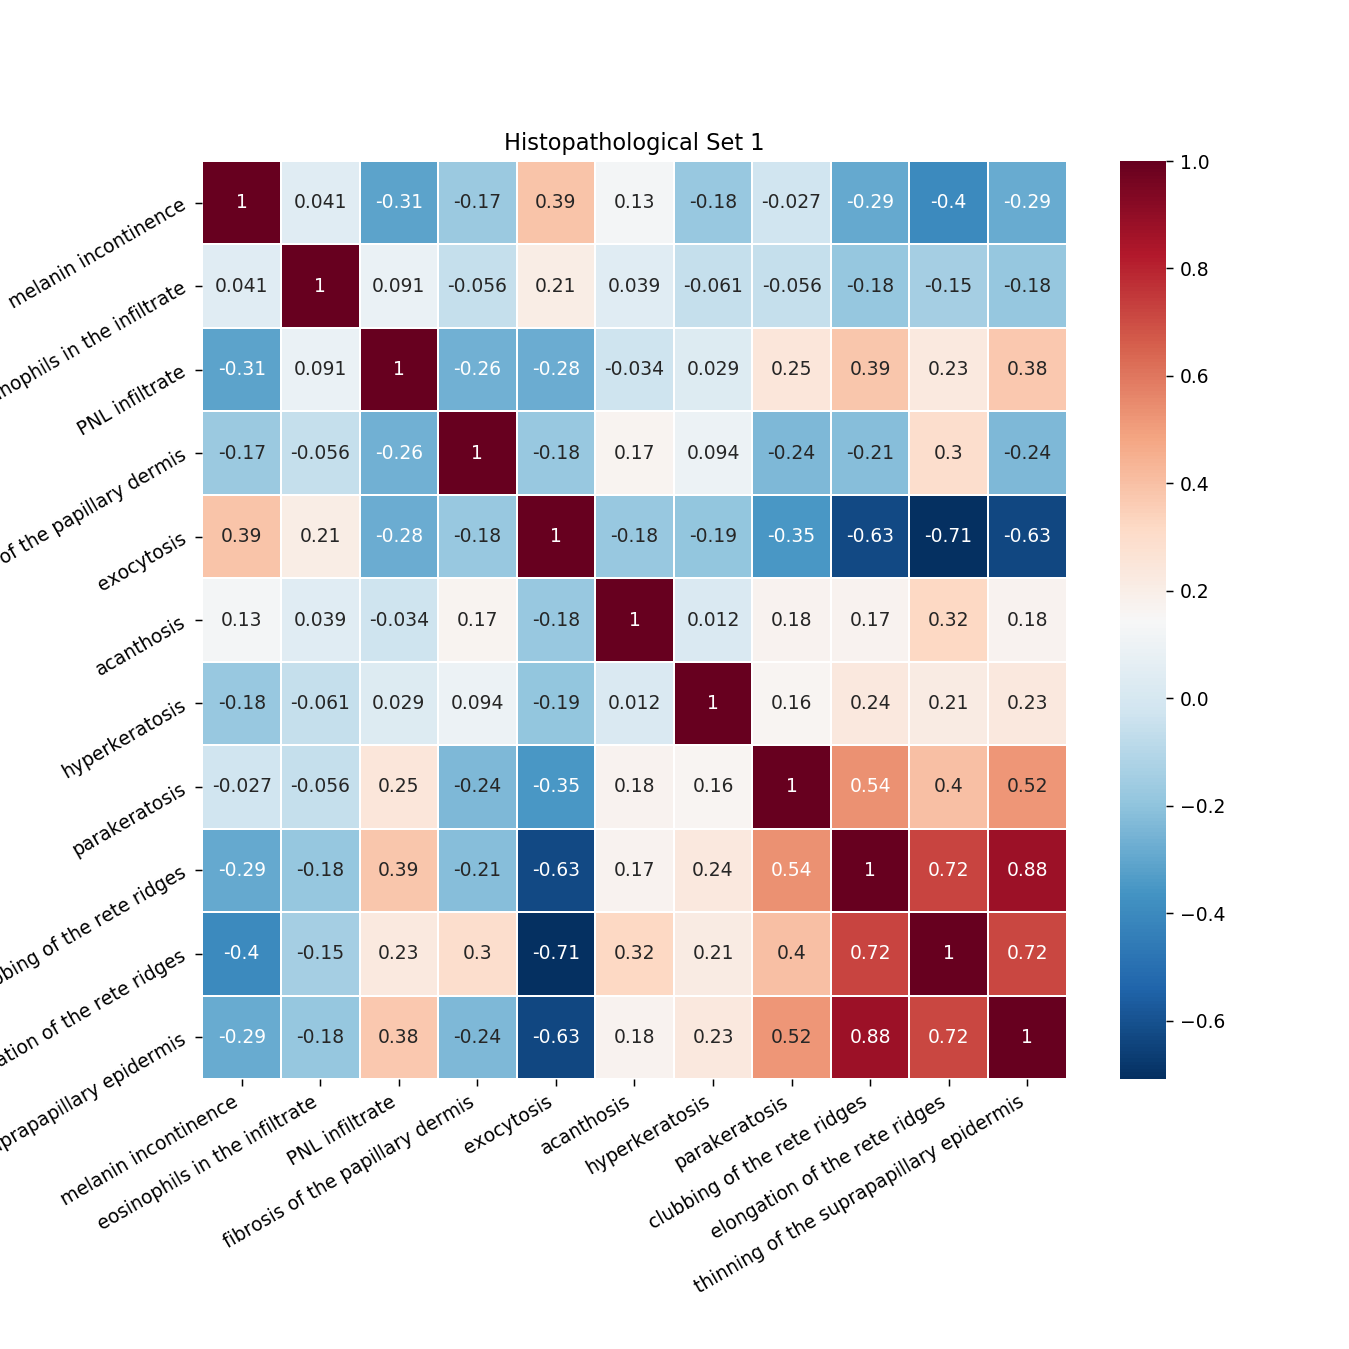

<IPython.core.display.Javascript object>


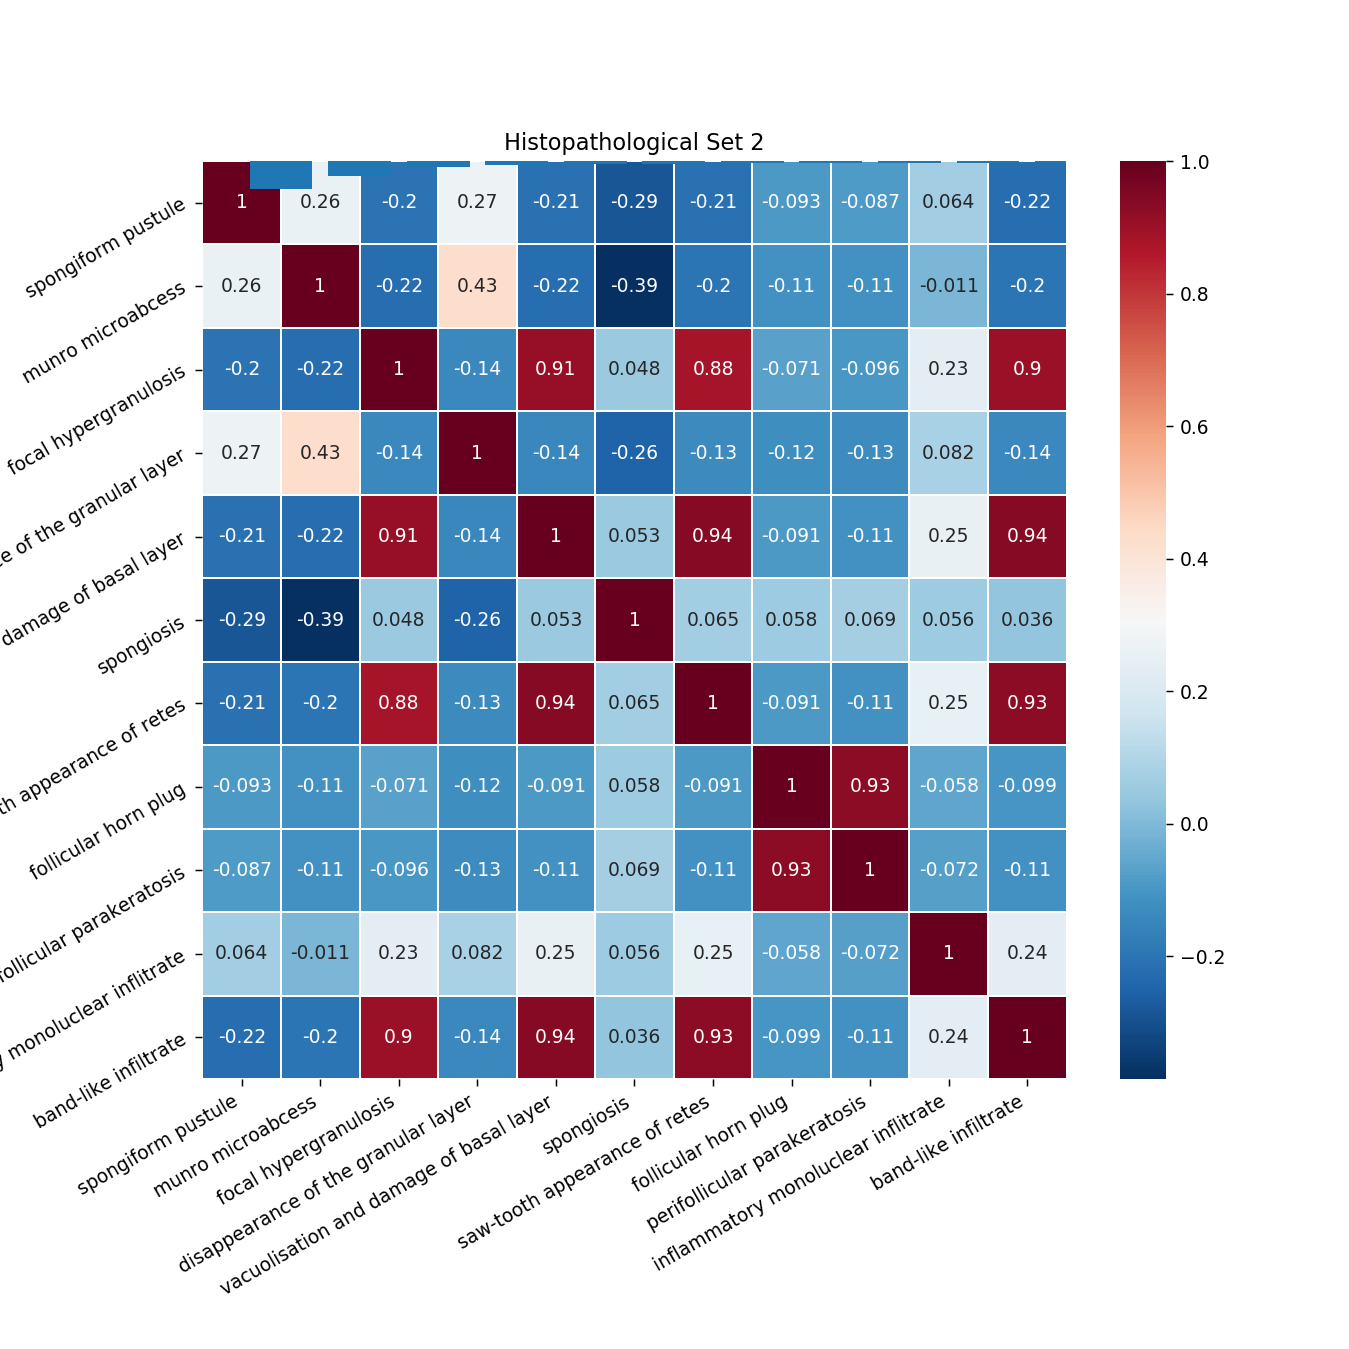

In [232]:
clin = list(df.columns[0:11])
clin.append(df.columns[33])

histo1 = list(df.columns[11:22])
histo2 = list(df.columns[22:33])

set_of_cols = [clin, histo1, histo2]
corr_title = ['Clincal Features', 'Histopathological Set 1', 'Histopathological Set 2']

# %matplotlib notebook
for col, ttl in zip(set_of_cols, corr_title):
    pearsoncorr = df[col].corr(method='pearson') #<- correlation matrix
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(pearsoncorr, 
                xticklabels=pearsoncorr.columns,
                yticklabels=pearsoncorr.columns,
                cmap='RdBu_r',
                annot=True,
                linewidth=0.5,
                ax=ax)
    plt.yticks(rotation=30)
    plt.xticks(rotation=30, ha='right')
    plt.title(ttl)
    fig.subplots_adjust(left=0.15, right=0.95, bottom=0.2)
pass;

- Two pairs of clinical features are correlated:
    - Oral mucosal involvement <> Polygonal Papules
    - Scalp involvement <> Knee and Elbow involvement
- Lots of correlated histopathological features:
    - Exocytosis <> 3 features
    - Parakeratosis <> 3 features
    - Clubbing of the rete ridges <> 2 features
    - Elongation of the rete ridges <> 1 features
    - Focal hypergranulosis <> 3 features
    - Vacuolisation and damage of basal layer <> 3 features
    - Saw-tooth appearance of retes <> 3 features
    - Perifollicular parakeratosis <> Follicular horn plug
    - Band-like infiltrate <> 3 features

<IPython.core.display.Javascript object>


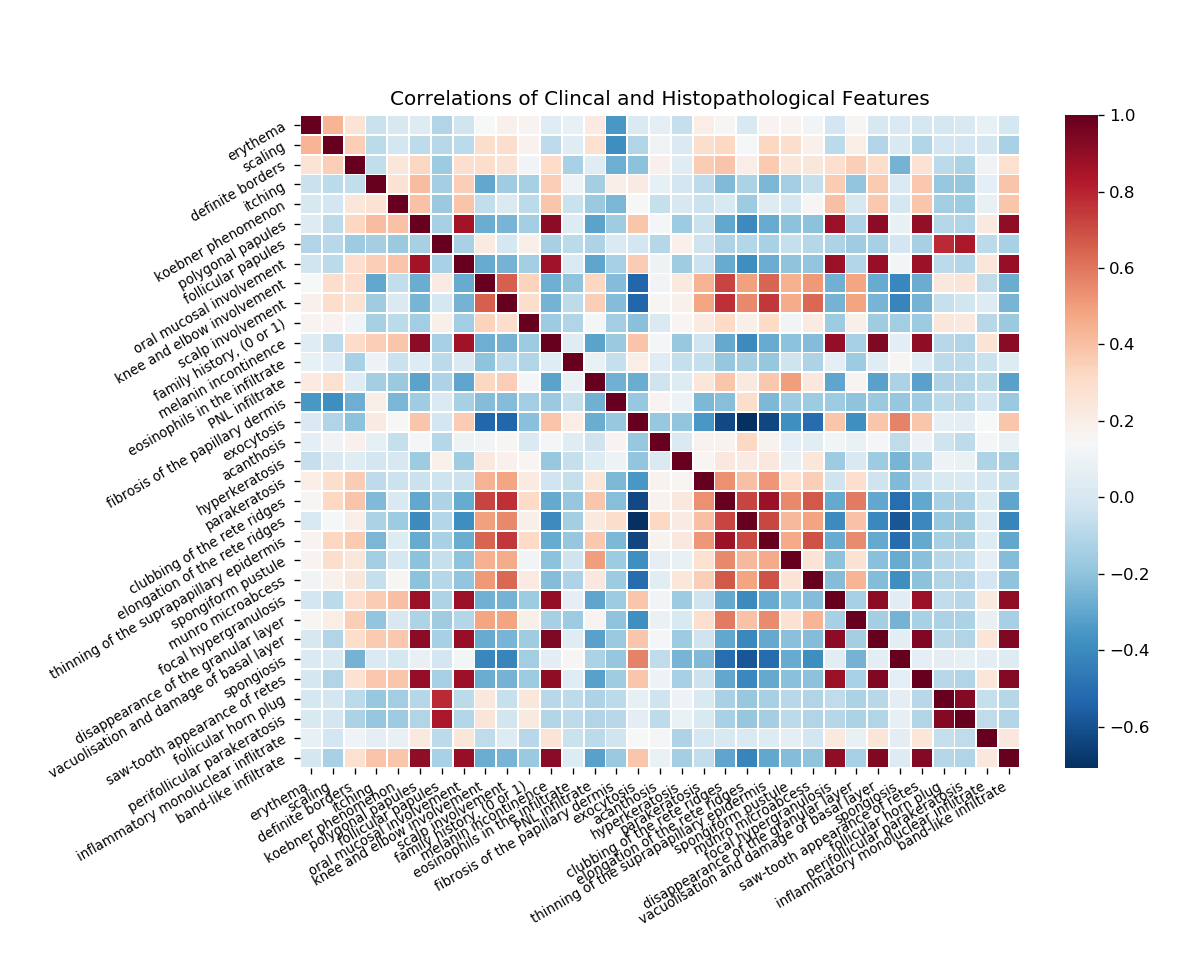

In [776]:
pearsoncorr = df.iloc[:, 0:33].corr(method='pearson') #<- correlation matrix
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
#             annot=True,
            linewidth=0.5,
            ax=ax)
plt.yticks(rotation=30)
plt.xticks(rotation=30, ha='right')
plt.title('Correlations of Clincal and Histopathological Features')
plt.ylabel(None)
ax.tick_params(axis='both', labelsize=8)
fig.subplots_adjust(left=0.25, right=1, bottom=0.2);

Given the moderate to high correlations between some features, it makes sense to group them into smaller number of factors using PCA, then visualize the K-Means clusters using the most important factors (principal components).

### WCSS, Wtihin-Cluster Sum of Square errors
- Already know we need 6 clusters based on disease class. Let's see what WCSS tells us.

[1052.9216273224042, 769.8897075333837, 556.431324696281, 492.1291884424255, 468.5066288793922, 429.53458667271, 414.0901796830135, 397.7131909519776, 385.8689328037056, 374.9283742370088]
[0.26880625532289143, 0.277258392661194, 0.11556167562808174, 0.04800072850342001, 0.08318354491567885, 0.03595614292514377, 0.03954932894948755, 0.029780903469460586, 0.028353043317592825]


<IPython.core.display.Javascript object>


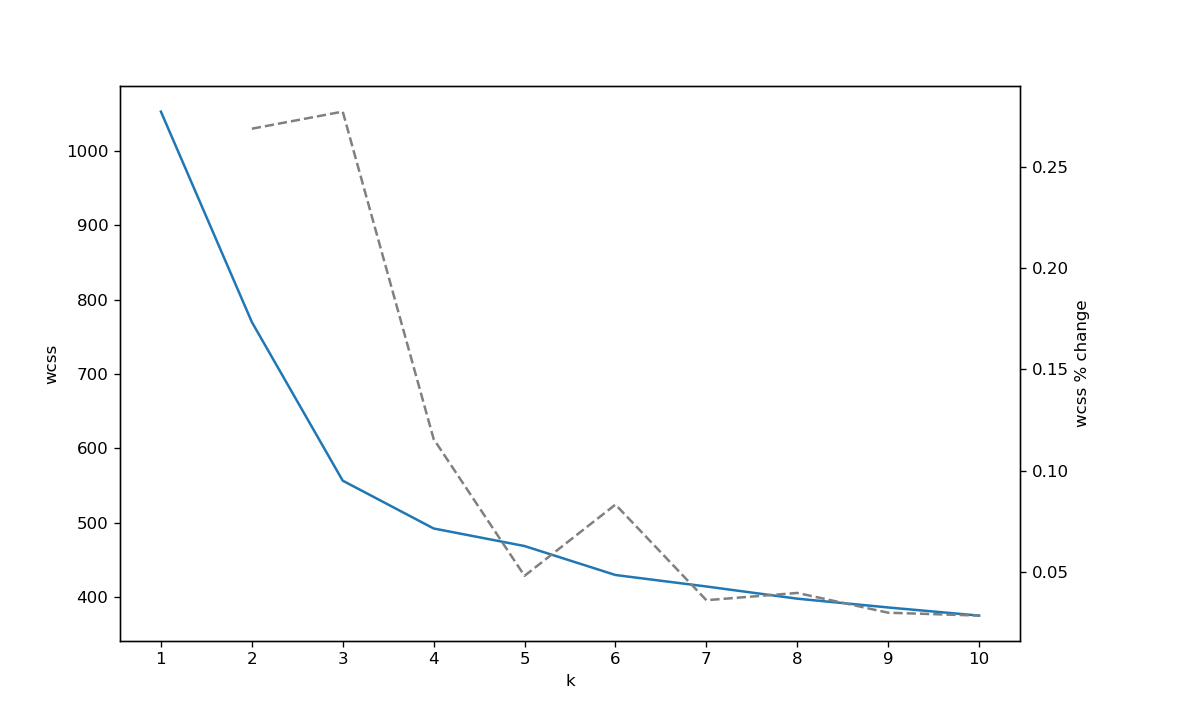

In [784]:
#fill in missing age with median value
df['Age (linear)'] = df['Age (linear)'].fillna(df['Age (linear)'].median())
# df.iloc[[33,34,35,36,262,263,264,265]]['Age (linear)']

#normalized features - all features range 0-3 except for age
X = df.iloc[:, :-2]
X_normalized = MinMaxScaler().fit_transform(X)

wcss = []
for i in range(1,11):
    model = KMeans(n_clusters=i, random_state=0)
    model.fit(X_normalized)
    wcss.append(model.inertia_)
    
wcss_delta = []
for i in range(0,9):
    pct = (wcss[i] - wcss[i+1])/wcss[i]
    wcss_delta.append(pct)
    
print(wcss)
print(wcss_delta)

# plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(range(1,11), wcss)
ax1.set_ylabel('wcss')
ax1.set_xlabel('k')
ax1.set_xticks(range(1,11))

ax2 = ax1.twinx()
ax2.plot(range(2,11), wcss_delta, color='grey', ls='--')
ax2.set_ylabel('wcss % change')

fig.subplots_adjust(left=0.1, right=0.85);

Looks like 4 to 6 clusters are reasonable

### PCA
- Want to visualize clusters by similarities in features and compare the clustering to the true disease classes
- But the feature space is high-dimensional (n_features = 34!)
- With PCA, reduce to 2D or 3D to visualize clusters
- Will use scree plot to observe how much variation is explained by increasing number of principal components
    - Hope to see majority of the variation being explained by the first two to three PCs

In [779]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_normalized)
X_pca = pca.transform(X_normalized)

### Understanding PCA output:
- eigenvalue = sum of squared distances between projected values and the origin (center of data)
    - The larger the eigenvalue, the more important the prinicipal component
- pca.explained_variance_ = eigenvalue/(n-1)
- pca.explained_variance_ratio_ = pca.explained_variance_/sum(pca.explained_variance_) = proportion of variation each prinicpal component accounts for --> visualize in scree plot
- pca.singular_values_ = sqrt(eigenvalue)
- [x**2/(len(X)-1) for x in pca.singular_values_] # Get back explained_variance
- pca.components_ = eigenvectors
    - Values in an eigenvector are loading scores = proportions of each feature Xi that constitute the prinicipal component
    - sum(loading score**2) = 1 bc eigenvector is a unit vector


### Scree Plot

<IPython.core.display.Javascript object>


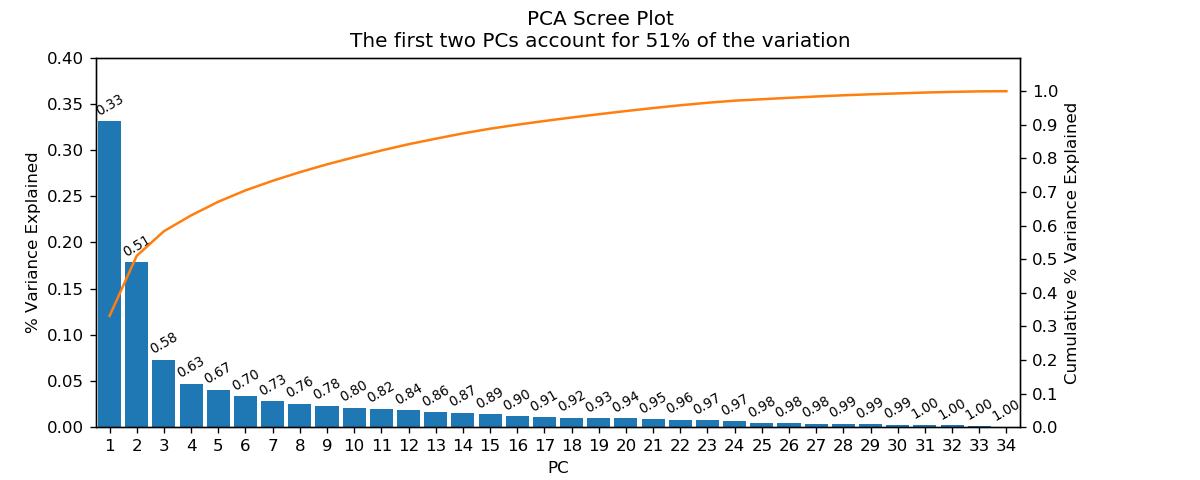

In [1058]:
var_ratio = pca.explained_variance_ratio_
cum = np.cumsum(pca.explained_variance_ratio_)

%matplotlib notebook
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

bar = ax1.bar(x=list(range(1,35)), height=var_ratio, width=0.85)
ax1.set_xlabel('PC')
ax1.set_ylabel('% Variance Explained')
ax1.set_xticks(np.arange(1,35))
ax1.set_xlim(0.5,34.5)
ax1.set_ylim(0,0.4)

ax2.plot(list(range(1,35)),cum, color='tab:orange')
ax2.set_ylabel('Cumulative % Variance Explained')  # we already handled the x-label with ax1
ax2.set_ylim(0,1.1)
ax2.set_yticks(np.arange(0,1.1,0.1))

fig.subplots_adjust(left=0.08, right=0.85)
fig.suptitle('PCA Scree Plot\nThe first two PCs account for {:2.0f}% of the variation'.format(cum[1]*100))


#Label each bar with cumulative % of variation explained
label = ['{:.2f}'.format(x) for x in cum]

for rect, lab in zip(bar.patches, label):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.003, lab,
            ha='center', va='bottom', fontsize=8, rotation=30)
pass;

### Important Features in First Three Prinicipal Components

In [646]:
pc = []
for i in range(3):
    _pc = pd.DataFrame(list(zip(df.columns[:-2], pca.components_[i])),
                  columns=['Feature', 'Loading_Score'])
    _pc['Rank'] = _pc['Loading_Score'].abs().rank(ascending=False).astype('int')
    _pc['Feature_Type'] = np.where(_pc['Feature'].isin(clin), 'Clinical', 'Histopathological')
    _pc.sort_values(by='Rank', inplace=True)
    pc.append(_pc)

<IPython.core.display.Javascript object>


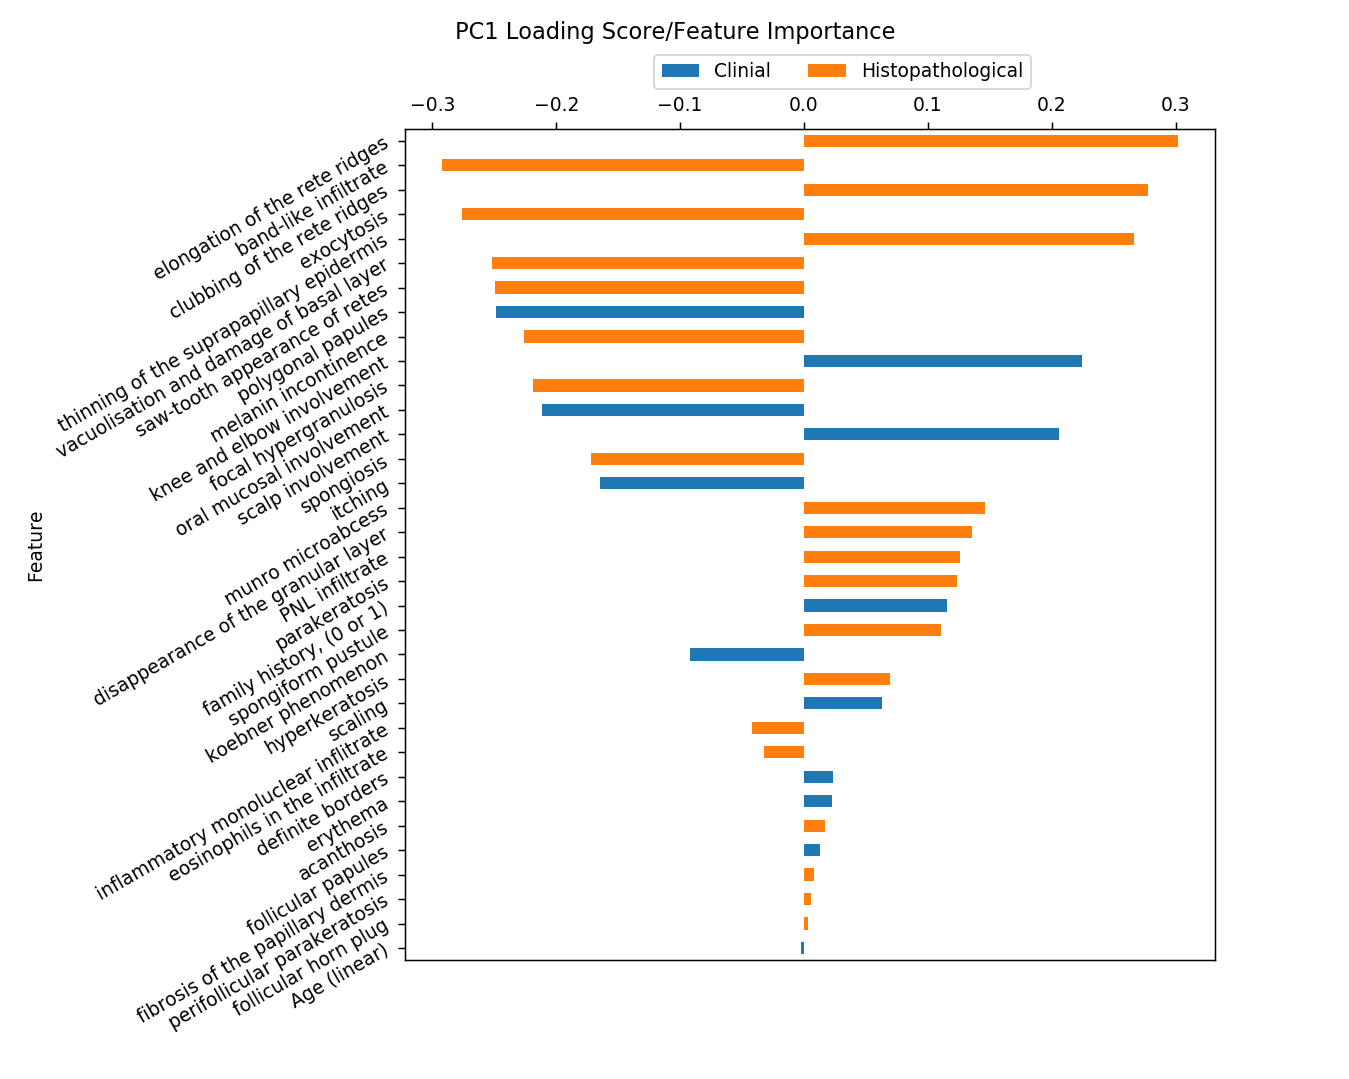

<IPython.core.display.Javascript object>


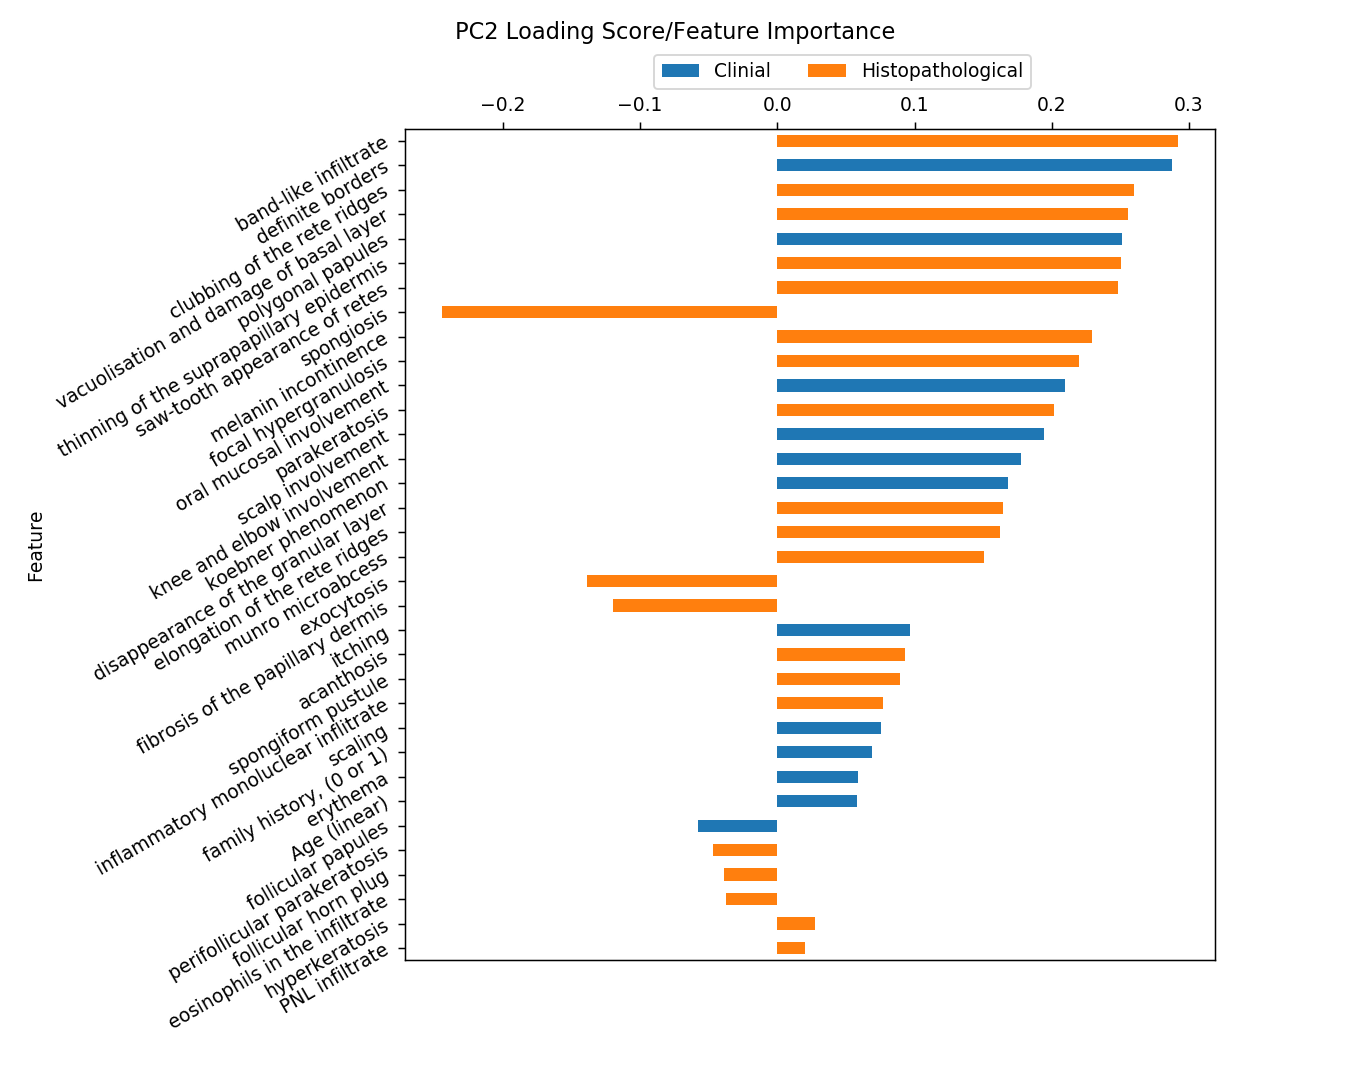

<IPython.core.display.Javascript object>


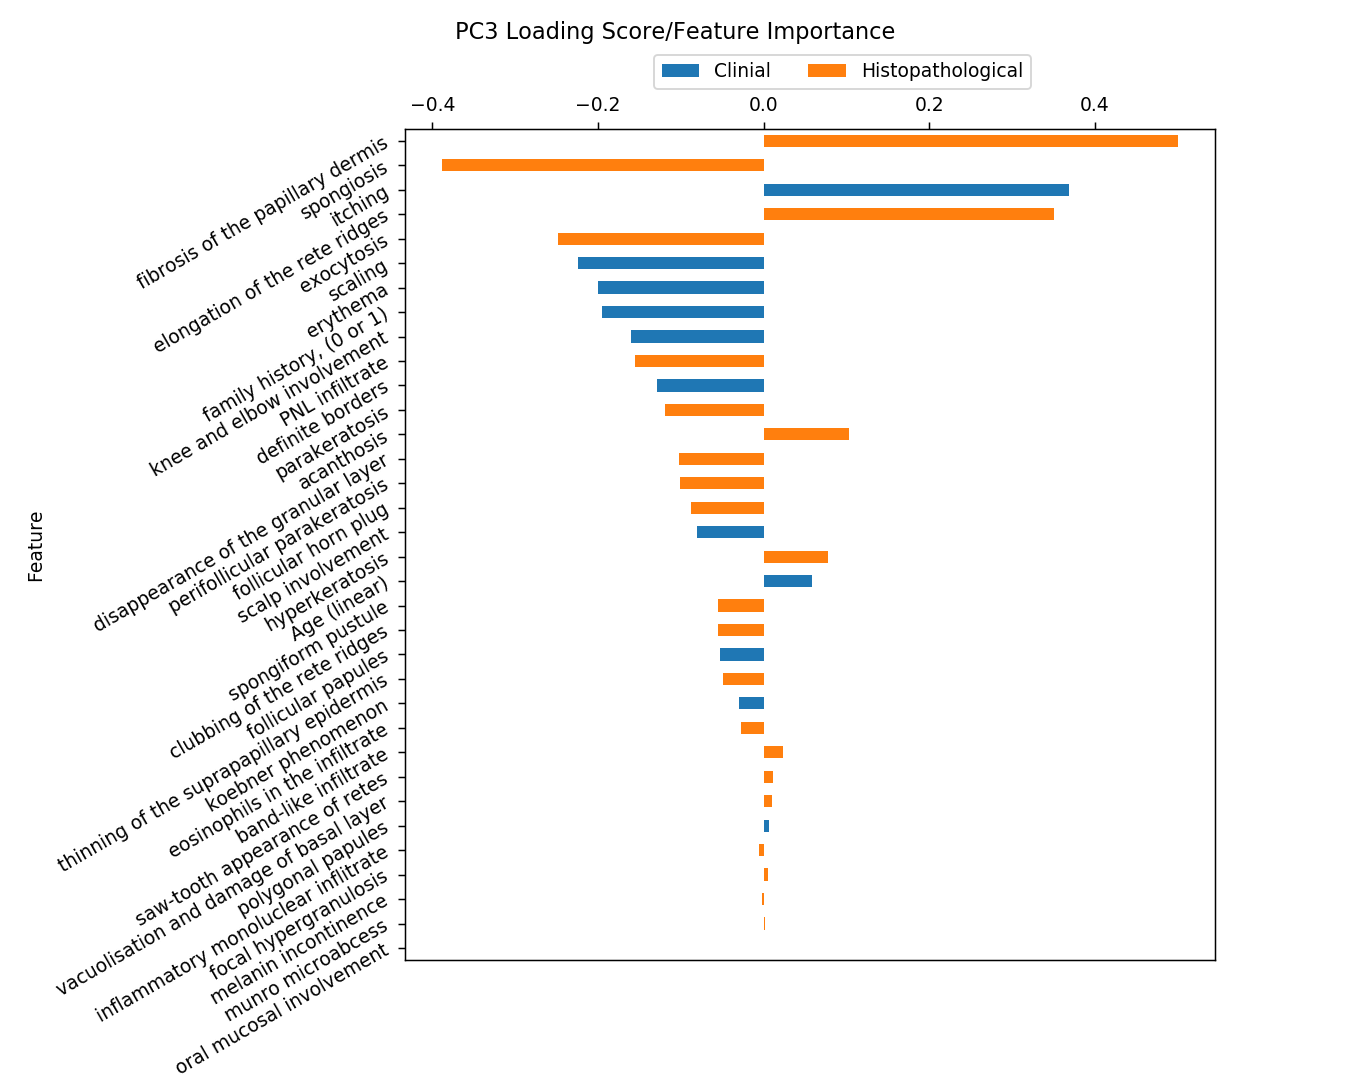

In [647]:
colors = {'Clinical': 'tab:blue',  'Histopathological': 'tab:orange'}

for i in range(3):
    fig, ax = plt.subplots(figsize=(10,8))
    l = pc[i].plot.barh(x = 'Feature',
                        y = 'Loading_Score',
                        color = pc[i]['Feature_Type'].map(colors),
                        ax = ax)
    plt.yticks(rotation=30)
    ax.xaxis.set_label_position('top') 
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    plt.xlabel(None)
    fig.subplots_adjust(left=0.3)
    fig.suptitle('PC{} Loading Score/Feature Importance'.format(i+1))

    # Add legend labels
    from matplotlib.patches import Patch
    l.legend(
            [
                Patch(facecolor=colors['Clinical']),
                Patch(facecolor=colors['Histopathological'])
            ],
            ["Clinial", "Histopathological"],
            bbox_to_anchor=(0.54, 1.1),
            loc='upper center',
            ncol=2  
        )
pass;

- Majority of the top features are histopathological

In [649]:
pd.DataFrame(list(zip(pc[0]['Feature'].head(10), 
                      pc[1]['Feature'].head(10),
                      pc[2]['Feature'].head(10))),
                  columns=['PC1', 'PC2', 'PC3'])

PC1  \
0             elongation of the rete ridges   
1                      band-like infiltrate   
2               clubbing of the rete ridges   
3                                exocytosis   
4  thinning of the suprapapillary epidermis   
5   vacuolisation and damage of basal layer   
6             saw-tooth appearance of retes   
7                         polygonal papules   
8                      melanin incontinence   
9                knee and elbow involvement   

                                        PC2                               PC3  
0                      band-like infiltrate  fibrosis of the papillary dermis  
1                          definite borders                        spongiosis  
2               clubbing of the rete ridges                           itching  
3   vacuolisation and damage of basal layer     elongation of the rete ridges  
4                         polygonal papules                        exocytosis  
5  thinning of the suprapapillary epidermis                           scaling  
6             saw-tooth appearance of retes                          erythema  
7                                spongiosis          family history, (0 or 1)  
8                      melanin incontinence        knee and elbow involvement  
9                     focal hypergranulosis                    PNL infiltrate

### 3D Scatter Plot for PCs by Disease Class

In [628]:
pca = PCA(n_components=3).fit(X_normalized)
X_pca = pca.transform(X_normalized)
pd.DataFrame(X_pca).head()

0         1         2
0 -0.457709 -0.939159 -0.161205
1  0.970862  0.551235 -0.272388
2 -1.623534  0.766445 -0.020557
3  1.453323  0.721074 -0.404307
4 -1.506097  0.926263 -0.141308

<IPython.core.display.Javascript object>


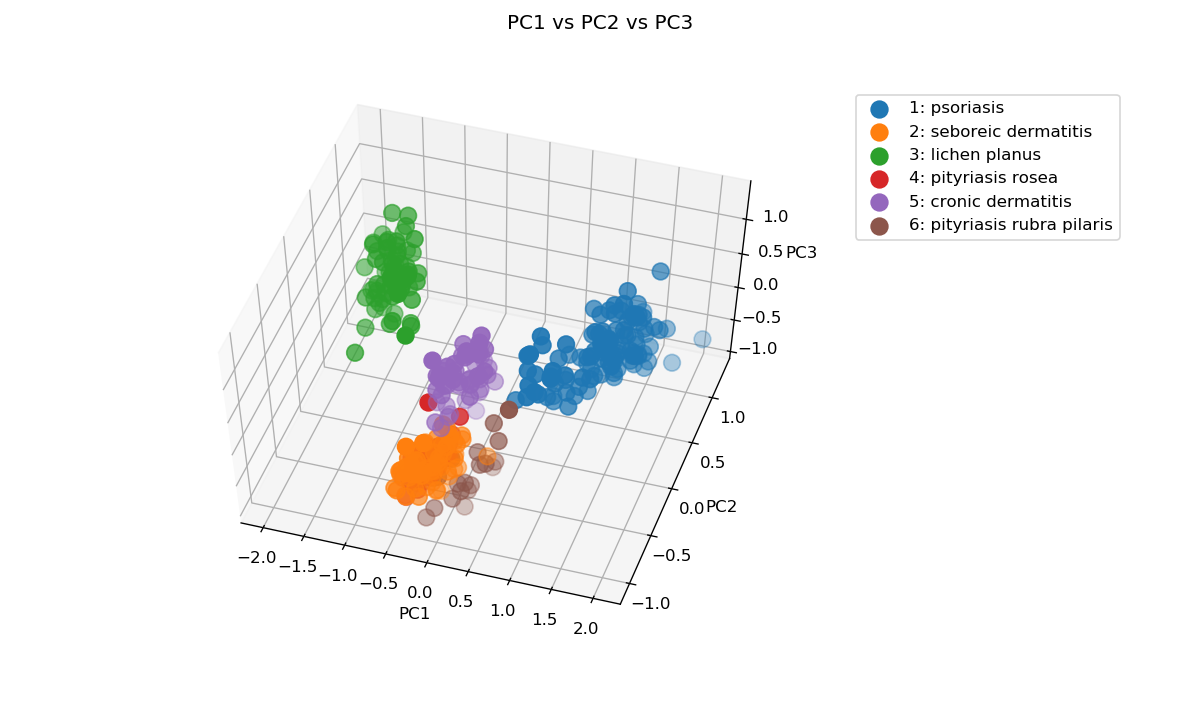

In [798]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
labels = ['1: psoriasis',
          '2: seboreic dermatitis',
          '3: lichen planus',
          '4: pityriasis rosea',
          '5: cronic dermatitis',
          '6: pityriasis rubra pilaris']

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1, projection='3d')
for i, lab in zip(range(1,7), labels):
    row_ix = np.where(df['Class_Code']==i)
    ax.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1], X_pca[row_ix, 2],
                s=100,
                label=lab
                )
    ax.legend(bbox_to_anchor=(1.4, 1))

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.suptitle('PC1 vs PC2 vs PC3')
fig.subplots_adjust(left=0.1, right = 0.7)
pass;

- By visulizaing the data in 3D, disease classes 1,3,5 are well-separated vs diases classes 2, 4, 6 are clumped together.
- Let's plot the three most important features in PC1:
    - elongation of the rete ridges
    - band-like infiltrate
    - clubbing of the rete ridges   
    
 and see how they explain the disease classes

### 3D Scatter Plot for Top 3 Features by Disease Class

<IPython.core.display.Javascript object>


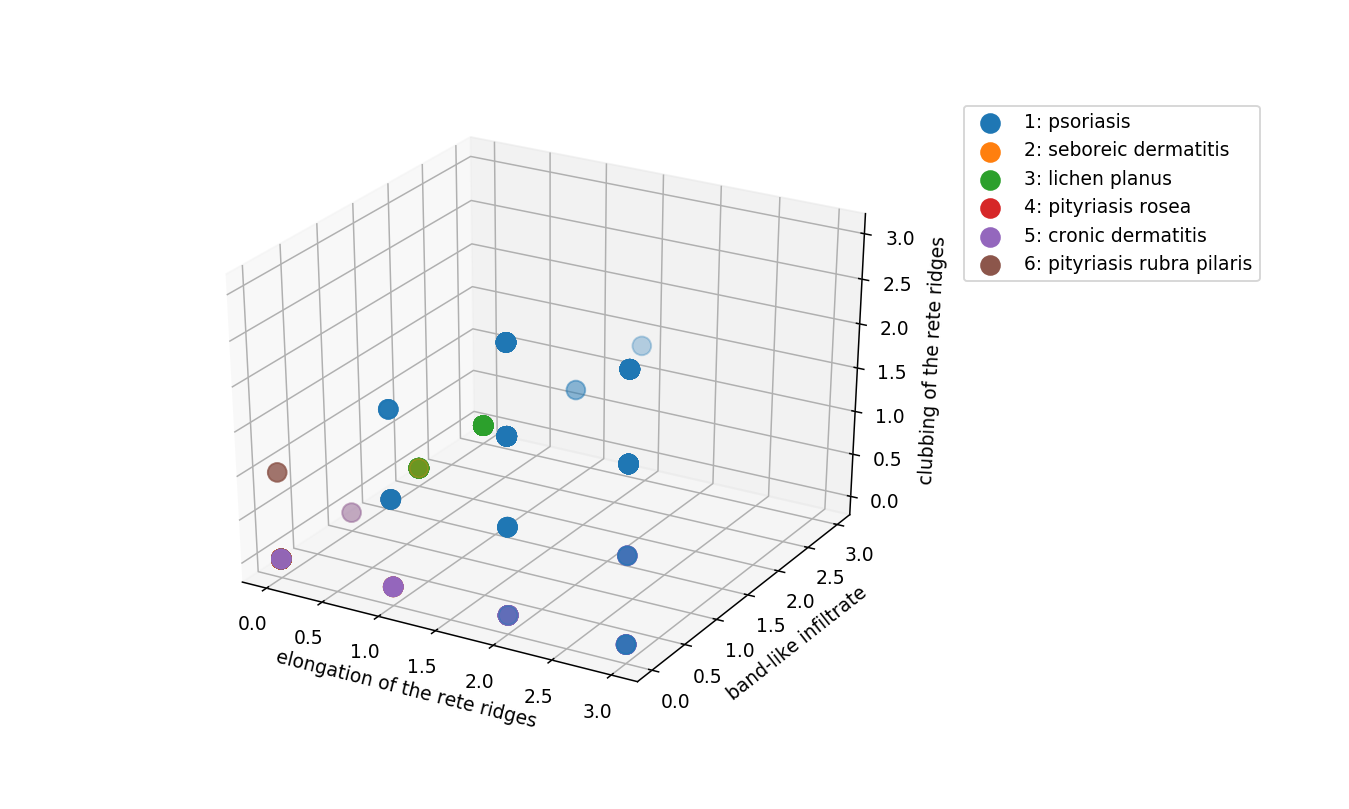

In [731]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
labels = ['1: psoriasis',
          '2: seboreic dermatitis',
          '3: lichen planus',
          '4: pityriasis rosea',
          '5: cronic dermatitis',
          '6: pityriasis rubra pilaris']

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1, projection='3d')
for i, lab in zip(range(1,7), labels):
    row_ix = np.where(df['Class_Code']==i)
    ax.scatter(X.iloc[row_ix]['elongation of the rete ridges'], 
               X.iloc[row_ix]['band-like infiltrate'],
               X.iloc[row_ix]['clubbing of the rete ridges'],
                s=100,
                label=lab
                )
    ax.legend(bbox_to_anchor=(1.4, 1))
    print()

ax.set_xlabel('elongation of the rete ridges')
ax.set_ylabel('band-like infiltrate')
ax.set_zlabel('clubbing of the rete ridges')
fig.subplots_adjust(left=0.1, right = 0.7)
pass;

In [756]:
#Print out majority counts by feature combination for each class
l = df.sort_values(by='Class_Code').groupby(['Class_Code',
            'elongation of the rete ridges',
            'band-like infiltrate', 
            'clubbing of the rete ridges']).size().\
    to_frame(name='N').reset_index().\
     sort_values(by=['Class_Code', 'N'], ascending=[True, False]).groupby('Class_Code').head(1)

total = df.groupby('Class_Code').size().rename('Total')
l=l.merge(right = total, how='left', on='Class_Code')
l['pct'] = l['N']/l['Total']
l

Class_Code  elongation of the rete ridges  band-like infiltrate  \
0           1                              2                     0   
1           2                              0                     0   
2           3                              0                     3   
3           4                              0                     0   
4           5                              2                     0   
5           6                              0                     0   

   clubbing of the rete ridges   N  Total       pct  
0                            2  38    112  0.339286  
1                            0  53     61  0.868852  
2                            0  52     72  0.722222  
3                            0  49     49  1.000000  
4                            0  30     52  0.576923  
5                            0  16     20  0.800000

- Different disease classes have their own characteristic features.
- The above three features are characteristics for disease classes 1, 3 and 5 and these classes account for majority of the data. Therefore these features dominate in the first PC.
- Majority (>=80%) of disease classes 2, 4, and 6 don't have any of these three features. That might explain the big agglomerate in the previous 3D plot.

### Visualize K-Mean Clustering
- If I don't know the disease class, can I find groupings by clustering the clinical and histopathological features?
- First, start with K-Mean clustering
- Next, explore other clustering methods

<IPython.core.display.Javascript object>


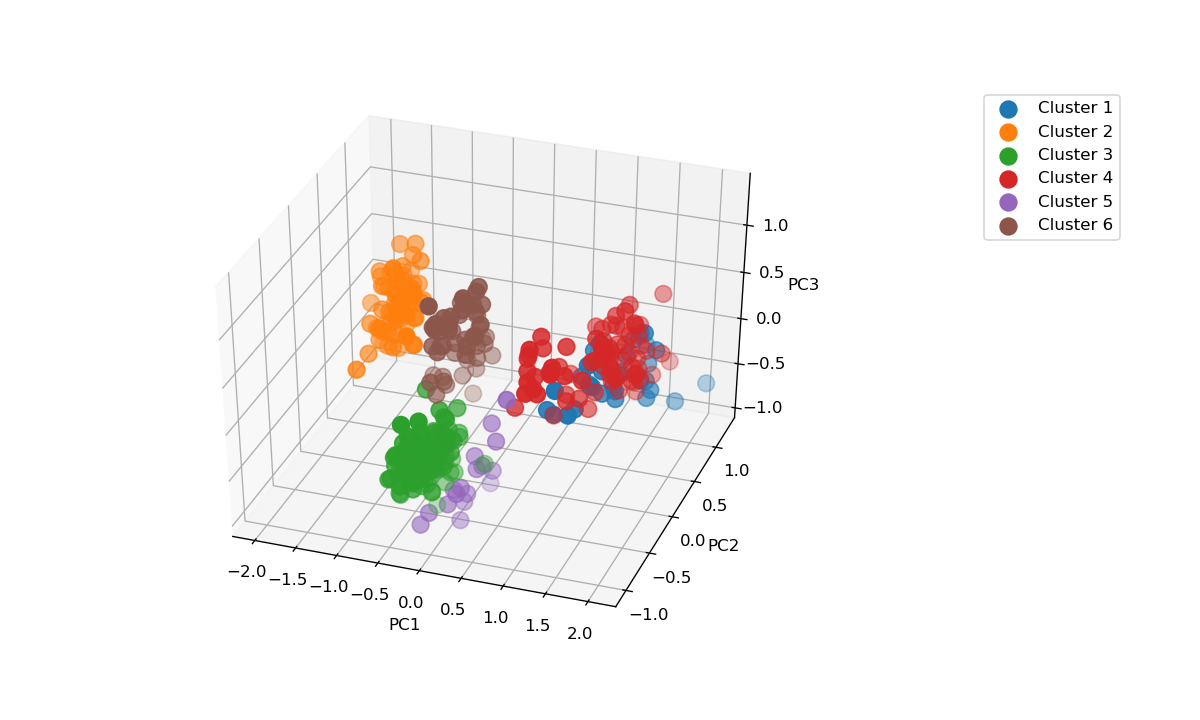

In [806]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X_normalized)
# kmeans.cluster_centers_.shape

# assign a cluster to each example
y_kmeans= kmeans.predict(X_normalized)
y_kmeans = kmeans.labels_ #same as predict(X_normalized) since input is the same X
y_kmeans = y_kmeans+1
# np.unique(y_kmeans)
%matplotlib notebook
# labels = ['1: psoriasis',
#           '2: seboreic dermatitis',
#           '3: lichen planus',
#           '4: pityriasis rosea',
#           '5: cronic dermatitis',
#           '6: pityriasis rubra pilaris']

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1, projection='3d')
for i, lab in zip(range(1,7), labels):
    row_ix = np.where(y_kmeans==i)
    ax.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1], X_pca[row_ix, 2],
                s=100,
                label='Cluster {}'.format(i)
                )
    ax.legend(bbox_to_anchor=(1.4, 1))

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.subplots_adjust(left=0.1, right = 0.7)
pass;

- The K-Mean clustering scatter plot looks rather similar to the actual disease class scatter plot
- Now apply other clustering methods and see how they compare to K-Means and the actual class
- Will use 2D scatter plot just to simiplfy the visual

### 2D Scatter Plots to Compare Different Types of Clustering with True Classes

<IPython.core.display.Javascript object>


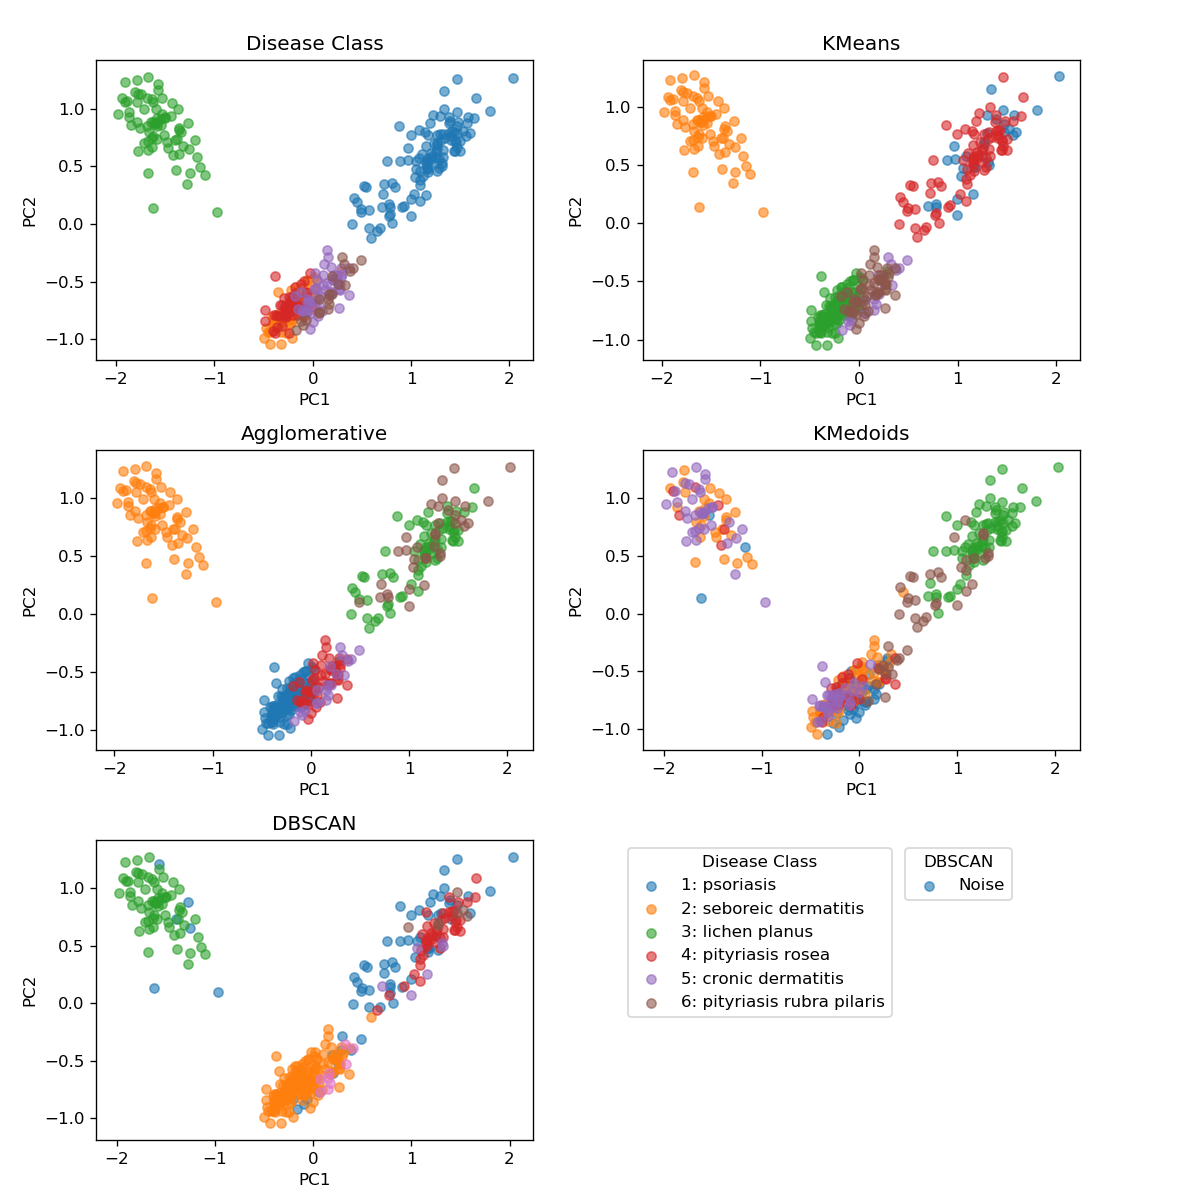

In [1005]:
%matplotlib notebook
dis_labels = ['1: psoriasis',
              '2: seboreic dermatitis',
              '3: lichen planus',
              '4: pityriasis rosea',
              '5: cronic dermatitis',
              '6: pityriasis rubra pilaris']

fig, [[ax0, ax1], [ax2, ax3], [ax4, ax5]]= plt.subplots(figsize=(10,10), nrows=3, ncols=2)

def scatterplot(y, labels, ax, title):
    unique_clusters = list(np.unique(y))
    if labels == None:
        cluster_labels = ['Cluster {}'.format(x) for x in list(np.unique(y))]
        
    else: cluster_labels = labels
    
    for i, lab in zip(unique_clusters, cluster_labels):
        row_ix = np.where(y==i)
        ax.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1],
                    s=30,
                    label=lab,
                    alpha = 0.6
                    )
#         if ax in [ax0, ax4]:
#             ax.legend(loc='lower center',
#                       bbox_to_anchor=(0.5, -0.6))
        
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title)
    
    #Cancel last ax object at the bottom right
    ax5.axis('off')
    
    #Disease class labels
    if ax == ax0:
        h, l = ax.get_legend_handles_labels()
        fig.legend(h, l, bbox_to_anchor = (0.75, 0.3), title='Disease Class')
        
    #DBSCAN noise label    
    if ax == ax4:
        h4, l4 = ax.get_legend_handles_labels()
        fig.legend((h4[0],), (l4[0],), bbox_to_anchor = (0.85, 0.3), title='DBSCAN')
        
        
    fig.subplots_adjust(left=0.08, right = 0.9, top = 0.95, bottom = 0.05, hspace = 0.3, wspace = 0.25)
    pass;

### Original disease class
scatterplot(y = df['Class_Code'], labels = dis_labels, ax=ax0, title = 'Disease Class')


### KMeans Clustering
kmeans = KMeans(n_clusters=6, random_state=0)
# assign a cluster to each example
y_kmeans = kmeans.fit_predict(X_normalized) #same as kmeans.fit(X_normalized).labels_ since input is the same X
y_kmeans = y_kmeans+1

scatterplot(y = y_kmeans, labels = None, ax=ax1, title = 'KMeans')


### KMedoids Clustering
kmedoids = KMedoids(n_clusters=6, random_state=0)
# assign a cluster to each example
y_kmedoids = kmedoids.fit_predict(X_normalized) #same as kmedoids.fit(X_normalized).labels_ since input is the same X
y_kmedoids = y_kmedoids+1

scatterplot(y = y_kmedoids, labels = None, ax=ax3, title = 'KMedoids')



### Agglomerative Clustering
y_agg = AgglomerativeClustering(n_clusters=6).fit_predict(X_normalized)
y_agg = y_agg+1

scatterplot(y = y_agg, labels = None, ax=ax2, title = 'Agglomerative')



### DBSCAN Clustering
dbscan = DBSCAN(eps=1.2, min_samples=6)

# assign a cluster to each example
y_dbscan= dbscan.fit_predict(X_normalized)
unique_dbscan_clusters = list(np.unique(y_dbscan))
y_dbscan_label = ['Noise' if x == -1 else 'Cluster {}'.format(x+1) for x in unique_dbscan_clusters]

scatterplot(y = y_dbscan, labels = y_dbscan_label, ax=ax4, title = 'DBSCAN')

- Of all the clustering methods, K-Means results in clusters most similar to the true disease classes
- Agglomerative clustering results are similar to K-Means
- K-Medoids performs the worst by considering data points that are further apart as one cluster and vice versa
- DBSCAN considers most of psoriasis class (top left data cloud) as noise

### PCA for just Disease Classes 2, 4, and 6
- What if I remove the three dominating disease classes and consider only the other diseases classes that are hard to separate?
- What features will be important to identify these classes?

In [1022]:
X_246 = X.iloc[np.where(df['Class_Code'].isin([2,4,6]))]

X_normalized_246 = MinMaxScaler().fit_transform(X_246)
pca246 = PCA().fit(X_normalized_246)

X_pca246 = pca246.transform(X_normalized_246)

pc_246 = []
for i in range(3):
    _pc = pd.DataFrame(list(zip(df.columns[:-2], pca246.components_[i])),
                  columns=['Feature', 'Loading_Score'])
    _pc['Rank'] = _pc['Loading_Score'].abs().rank(ascending=False).astype('int')
    _pc['Feature_Type'] = np.where(_pc['Feature'].isin(clin), 'Clinical', 'Histopathological')
    _pc.sort_values(by='Rank', inplace=True)
    pc_246.append(_pc)
    
    print('PC{}:\n'.format(i+1))
    _pc.head()


PC1:



Feature  Loading_Score  Rank       Feature_Type
6             follicular papules       0.434964     1           Clinical
30  perifollicular parakeratosis       0.400358     2  Histopathological
29          follicular horn plug       0.357537     3  Histopathological
8     knee and elbow involvement       0.340069     4           Clinical
10      family history, (0 or 1)       0.298274     5           Clinical

PC2:



Feature  Loading_Score  Rank       Feature_Type
3              itching       0.487758     1           Clinical
2     definite borders      -0.447906     2           Clinical
4   koebner phenomenon      -0.301326     3           Clinical
13      PNL infiltrate       0.294078     4  Histopathological
0             erythema       0.287721     5           Clinical

PC3:



Feature  Loading_Score  Rank       Feature_Type
2   definite borders       0.645310     1           Clinical
1            scaling       0.386149     2           Clinical
0           erythema       0.366309     3           Clinical
16        acanthosis       0.267951     4  Histopathological
27        spongiosis       0.214549     5  Histopathological

- The top features for the new PCs are mostly clinical now

### Scree Plot Again
- For just disease classes 2, 4, and 6

<IPython.core.display.Javascript object>


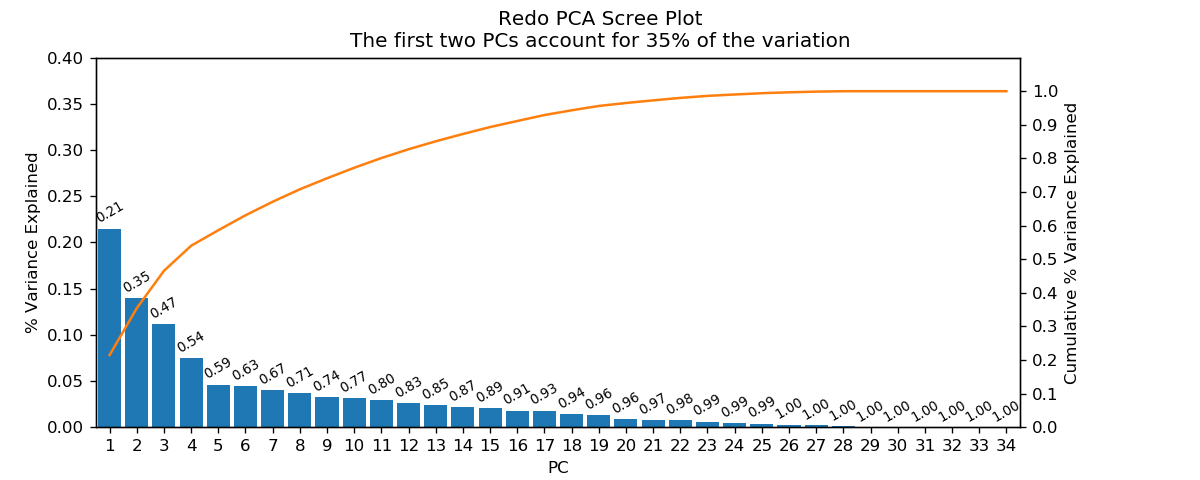

In [1059]:
var_ratio = pca246.explained_variance_ratio_
cum = np.cumsum(pca246.explained_variance_ratio_)

%matplotlib notebook
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

bar = ax1.bar(x=list(range(1,35)), height=var_ratio, width=0.85)
ax1.set_xlabel('PC')
ax1.set_ylabel('% Variance Explained')
ax1.set_xticks(np.arange(1,35))
ax1.set_xlim(0.5,34.5)
ax1.set_ylim(0,0.4)

ax2.plot(list(range(1,35)), cum, color='tab:orange')
ax2.set_ylabel('Cumulative % Variance Explained')  # we already handled the x-label with ax1
ax2.set_ylim(0,1.1)
ax2.set_yticks(np.arange(0,1.1,0.1))

fig.subplots_adjust(left=0.08, right=0.85)
fig.suptitle('Redo PCA Scree Plot\nThe first two PCs account for {:2.0f}% of the variation'.format(cum[1]*100))

#Label each bar with cumulative % of variation explained
label = ['{:.2f}'.format(x) for x in cum]

for rect, lab in zip(bar.patches, label):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.003, lab,
            ha='center', va='bottom', fontsize=8, rotation=30)
pass;

### Visualize K-Means Clusters Again

<IPython.core.display.Javascript object>


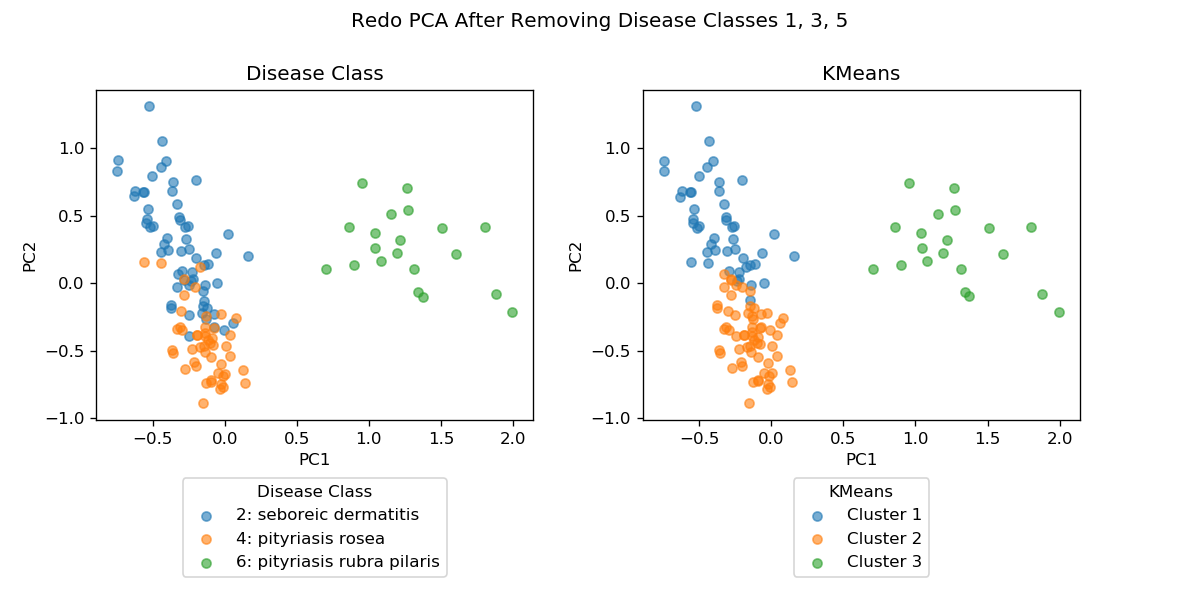

In [1049]:
%matplotlib notebook
dis_labels = ['2: seboreic dermatitis',
              '4: pityriasis rosea',
              '6: pityriasis rubra pilaris']

fig, [ax0, ax1]= plt.subplots(figsize=(10,5), nrows=1, ncols=2)

def scatterplot2(y, labels, ax, title):
    unique_clusters = list(np.unique(y))
    if labels == None:
        cluster_labels = ['Cluster {}'.format(x) for x in list(np.unique(y))]
        
    else: cluster_labels = labels
    
    for i, lab in zip(unique_clusters, cluster_labels):
        row_ix = np.where(y==i)
        ax.scatter(X_pca246[row_ix, 0], X_pca246[row_ix, 1],
                    s=30,
                    label=lab,
                    alpha = 0.6
                    )
       
        ax.legend(loc='lower center',
                  bbox_to_anchor=(0.5, -0.5),
                  title=title)
        
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title)
    
    
    fig.suptitle('Redo PCA After Removing Disease Classes 1, 3, 5')
    fig.subplots_adjust(left=0.08, right = 0.9, top = 0.85, bottom = 0.3, hspace = 0.3, wspace = 0.25)
    pass;

### Original disease class
scatterplot2(y = df.loc[df['Class_Code'].isin([2,4,6]), 'Class_Code'], labels = dis_labels, ax=ax0, title = 'Disease Class')


kmeans = KMeans(n_clusters=3, random_state=0)
# assign a cluster to each example
y_kmeans_246 = kmeans.fit_predict(X_normalized_246) #same as kmeans.fit(X_normalized).labels_ since input is the same X
y_kmeans_246 = y_kmeans_246+1

scatterplot2(y = y_kmeans_246, labels = None, ax=ax1, title = 'KMeans')

### Check the top feature values in each PC for each cluster
- follicular papules
- itching
- definite borders

In [1120]:
df_246 = df.loc[df['Class_Code'].isin([2,4,6])]
df_246['cluster'] = y_kmeans_246
# df_246.head()

a = df_246.groupby('cluster')[['follicular papules', 'itching', 'definite borders']].describe().T
#rename columns 1,2,3 to cluster_1, cluster_2, cluster_3
a.columns = list(map(lambda x: 'Cluster_{}'.format(x), a.columns))

b = df_246.groupby('Class_Code')[['follicular papules', 'itching', 'definite borders']].describe().T
#rename columns 2,4,6 to class_2, class_4, class_6
b.columns = list(map(lambda x: 'Class_{}'.format(x), b.columns))

a.merge(right=b, how='left', left_index=True, right_index=True)

C:\Users\tuttoaposto\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Cluster_1  Cluster_2  Cluster_3    Class_2  \
follicular papules count  47.000000  63.000000  20.000000  61.000000   
                   mean    0.000000   0.015873   2.200000   0.016393   
                   std     0.000000   0.125988   0.615587   0.128037   
                   min     0.000000   0.000000   1.000000   0.000000   
                   25%     0.000000   0.000000   2.000000   0.000000   
                   50%     0.000000   0.000000   2.000000   0.000000   
                   75%     0.000000   0.000000   3.000000   0.000000   
                   max     0.000000   1.000000   3.000000   1.000000   
itching            count  47.000000  63.000000  20.000000  61.000000   
                   mean    1.872340   0.539683   0.500000   1.622951   
                   std     0.875190   0.758296   0.606977   0.951559   
                   min     0.000000   0.000000   0.000000   0.000000   
                   25%     1.000000   0.000000   0.000000   1.000000   
                   50%     2.000000   0.000000   0.000000   2.000000   
                   75%     2.000000   1.000000   1.000000   2.000000   
                   max     3.000000   3.000000   2.000000   3.000000   
definite borders   count  47.000000  63.000000  20.000000  61.000000   
                   mean    0.744681   1.285714   1.050000   0.950820   
                   std     0.793125   0.682230   0.759155   0.804699   
                   min     0.000000   0.000000   0.000000   0.000000   
                   25%     0.000000   1.000000   0.750000   0.000000   
                   50%     1.000000   1.000000   1.000000   1.000000   
                   75%     1.000000   2.000000   2.000000   2.000000   
                   max     2.000000   2.000000   2.000000   2.000000   

                            Class_4    Class_6  
follicular papules count  49.000000  20.000000  
                   mean    0.000000   2.200000  
                   std     0.000000   0.615587  
                   min     0.000000   1.000000  
                   25%     0.000000   2.000000  
                   50%     0.000000   2.000000  
                   75%     0.000000   3.000000  
                   max     0.000000   3.000000  
itching            count  49.000000  20.000000  
                   mean    0.469388   0.500000  
                   std     0.766541   0.606977  
                   min     0.000000   0.000000  
                   25%     0.000000   0.000000  
                   50%     0.000000   0.000000  
                   75%     1.000000   1.000000  
                   max     3.000000   2.000000  
definite borders   count  49.000000  20.000000  
                   mean    1.183673   1.050000  
                   std     0.726678   0.759155  
                   min     0.000000   0.000000  
                   25%     1.000000   0.750000  
                   50%     1.000000   1.000000  
                   75%     2.000000   2.000000  
                   max     2.000000   2.000000

The three clusters map very well to the disease classes 2, 4, and 6 with the three distinct clinical features:
- Cluster 1 (Class 2) tends to have high itching presence
- Cluster 2 (Class 4) has slightly more definite borders presence but low to intermediate presence in the other two features
- Cluster 3 (Class 6) tends to have high follicular papules presence

### Conclusion
- Disease classes seem to consist of two big categories: classes 1, 3, and 5 and classes 2, 4, and 6
- Disease classes 1, 3, and 5 (psoriasis, lichen planus, cronic dermatitis) have more distinct histopathological features
- Disease classes 2, 4, and 6 (seboreic dermatitis, pityriasis rosea, pityriasis rubra pilaris) have more distinct clinical features
- K-Means produces the best clustering for this type of data, among other clustering methods explored here